## Aluno: Fernando Gomes Papi

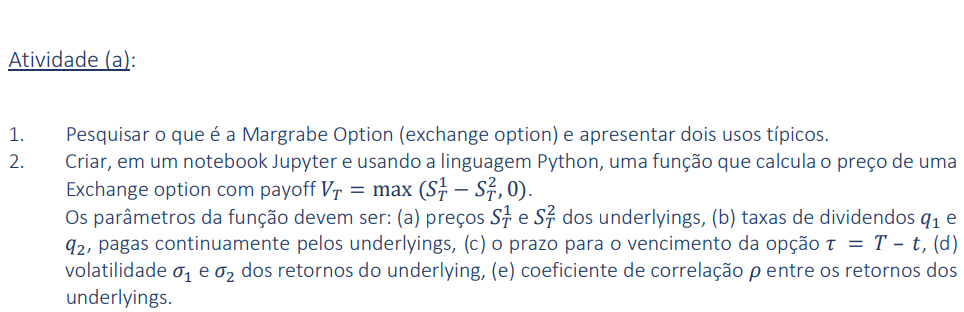

Opções Margrabe, ou *exchange options* são opções para se trocar um ativo por outro ao final do contrato.

Elas podem ser utilizadas para se trocar 2 moedas estrangeiras a um preço pré-determinado, por motivo de hedging de câmbio.

Outro caso de uso seria o hedge de uma empresa de seguros, que consegue se proteger de insolvência ao adquirir uma exchange option entre seu portfolio de ativos e um *valuation portfolio* (um portfolio replicante dos fluxos de caixa descontados do portfolio de ativos) [https://www.scirp.org/html/6-1490231_43336_43336.htm]

Também há usos no trade de commodities [https://arxiv.org/pdf/cond-mat/9904110.pdf], como por exemplo, na troca do petróleo refinado pelo petróleo cru devido a varições de demanda e produção

In [102]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import pearsonr
from aleatory.processes import GBM

def exchange_option_price(ST1, ST2, q1, q2, tau, sigma1, sigma2, rho):
    # Calcular os valores d1 e d2 para a opção de troca
    sigma = np.sqrt(sigma1**2 + sigma2**2 - 2*rho*sigma1*sigma2)
    
    d1 = (np.log(ST1 / ST2) + (q1 - q2 + 0.5*(sigma**2)) * tau) /(sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)

    # Calcular o preço da opção
    option_price = ST1*np.exp(-q1*tau)*norm.cdf(d1) - ST2*np.exp(-q2*tau)*norm.cdf(d2)

    return option_price

# Exemplo de uso da função
ST1 = 100  # Preço do ativo subjacente 1
ST2 = 90   # Preço do ativo subjacente 2
q1 = 0.02  # Taxa de dividendos do ativo subjacente 1
q2 = 0.03  # Taxa de dividendos do ativo subjacente 2
tau = 1  # Prazo para o vencimento da opção
sigma1 = 0.2  # Volatilidade do ativo subjacente 1
sigma2 = 0.3  # Volatilidade do ativo subjacente 2
rho = 0.22    # Coeficiente de correlação entre os ativos subjacentes

option_price = exchange_option_price(ST1, ST2, q1, q2, tau, sigma1, sigma2, rho)
print(f"O preço da Exchange Option é: {option_price :.2f}")

O preço da Exchange Option é: 17.91


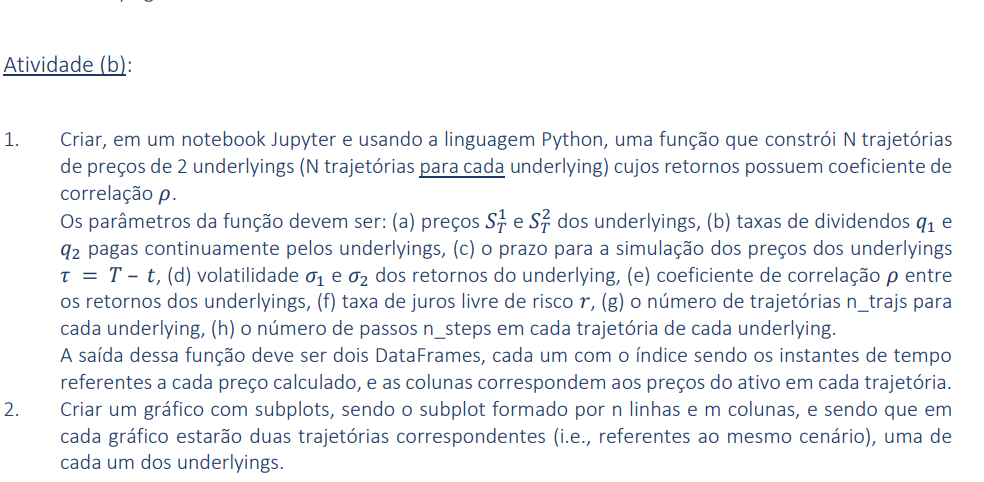

In [234]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0_1 = 100  # Initial price of the first asset
S0_2 = 20  # Initial price of the second asset
mu_1 = 0.2  # Drift of the first asset
mu_2 = 0.6  # Drift of the second asset
sigma_1 = 0.20  # Volatility of the first asset
sigma_2 = 0.45  # Volatility of the second asset
q1 = 0.02  # Taxa de dividendos do ativo subjacente 1
q2 = 0.01  # Taxa de dividendos do ativo subjacente 2
T = 1.0  # Total time
dt = 1/252  # Time step (e.g., daily data for one year)

rho = 0.4  # Correlation between the two assets

price_0 = exchange_option_price(S0_1, S0_2, q1, q2, T, sigma1, sigma2, rho)


def correlated_geometric_brownian_motion(mu_1, mu_2, sigma_1, sigma_2, S0_1, S0_2,
                                         q1, q2, T, dt, rho, n_series):
    
    # Calculate the number of time steps based on the total time and time step
    num_steps = int(T / dt)
    C = np.array([[1, rho],[rho, 1]])
    L = np.linalg.cholesky(C)

    # Generate random increments for the Wiener process
    def generate_series():
        # Using cholesky decomposition to generate correlated shocks
        # @ is np.dot()
        dW = L @ np.random.default_rng().normal(loc=0.0, scale=np.sqrt(dt), size=(2, 1000))
        
        dW_1 = dW[0]
        dW_2 = dW[1]
                
        # Create an array to store the asset price values
        S_1 = np.zeros(num_steps + 1)
        S_2 = np.zeros(num_steps + 1)
        prices = np.zeros(num_steps + 1)
        
        
        S_1[0] = S0_1  # Set the initial asset price
        S_2[0] = S0_2  # Set the initial asset price
        prices[0] = exchange_option_price(S0_1, S0_2, q1, q2, T, sigma1, sigma2, rho)

        # Loop through each time step
        for i in range(num_steps):
            # Calculate the change in the asset price at the current step
            dS_1 = mu_1 * S_1[i] * dt + sigma_1 * S_1[i] * dW_1[i]
            dS_2 = mu_2 * S_2[i] * dt + sigma_2 * S_2[i] * dW_2[i]
        
            # Update the asset price for the next time step
            S_1[i + 1] = S_1[i] + dS_1
            S_2[i + 1] = S_2[i] + dS_2
            tau = (i+1)*dt
            prices[i+1] = exchange_option_price(S_1[i + 1], S_2[i + 1], 
                                                q1, q2, T-tau, sigma1, sigma2, rho)

        return {'s1': S_1, 's2': S_2, 'ex_op_price': prices}

    all_series = [generate_series() for n in np.arange(0,n_series)]

    df1 = pd.DataFrame({idx: s['s1'] for idx, s in enumerate(all_series)}, index=np.arange(num_steps+1)*dt)
    df2 = pd.DataFrame({idx: s['s2'] for idx, s in enumerate(all_series)}, index=np.arange(num_steps+1)*dt)
    df_prices = pd.DataFrame({idx: s['ex_op_price'] for idx, s in enumerate(all_series)}, index=np.arange(num_steps+1)*dt)
    
    return df1, df2, df_prices

S1, S2, df_prices = correlated_geometric_brownian_motion(
                    mu_1, mu_2, 
                    sigma_1, sigma_2, 
                    S0_1, S0_2, q1, q2,
                    T, dt, rho, 10)

/tmp/ipykernel_33602/2438606018.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(ST1 / ST2) + (q1 - q2 + 0.5*(sigma**2)) * tau) /(sigma*np.sqrt(tau))


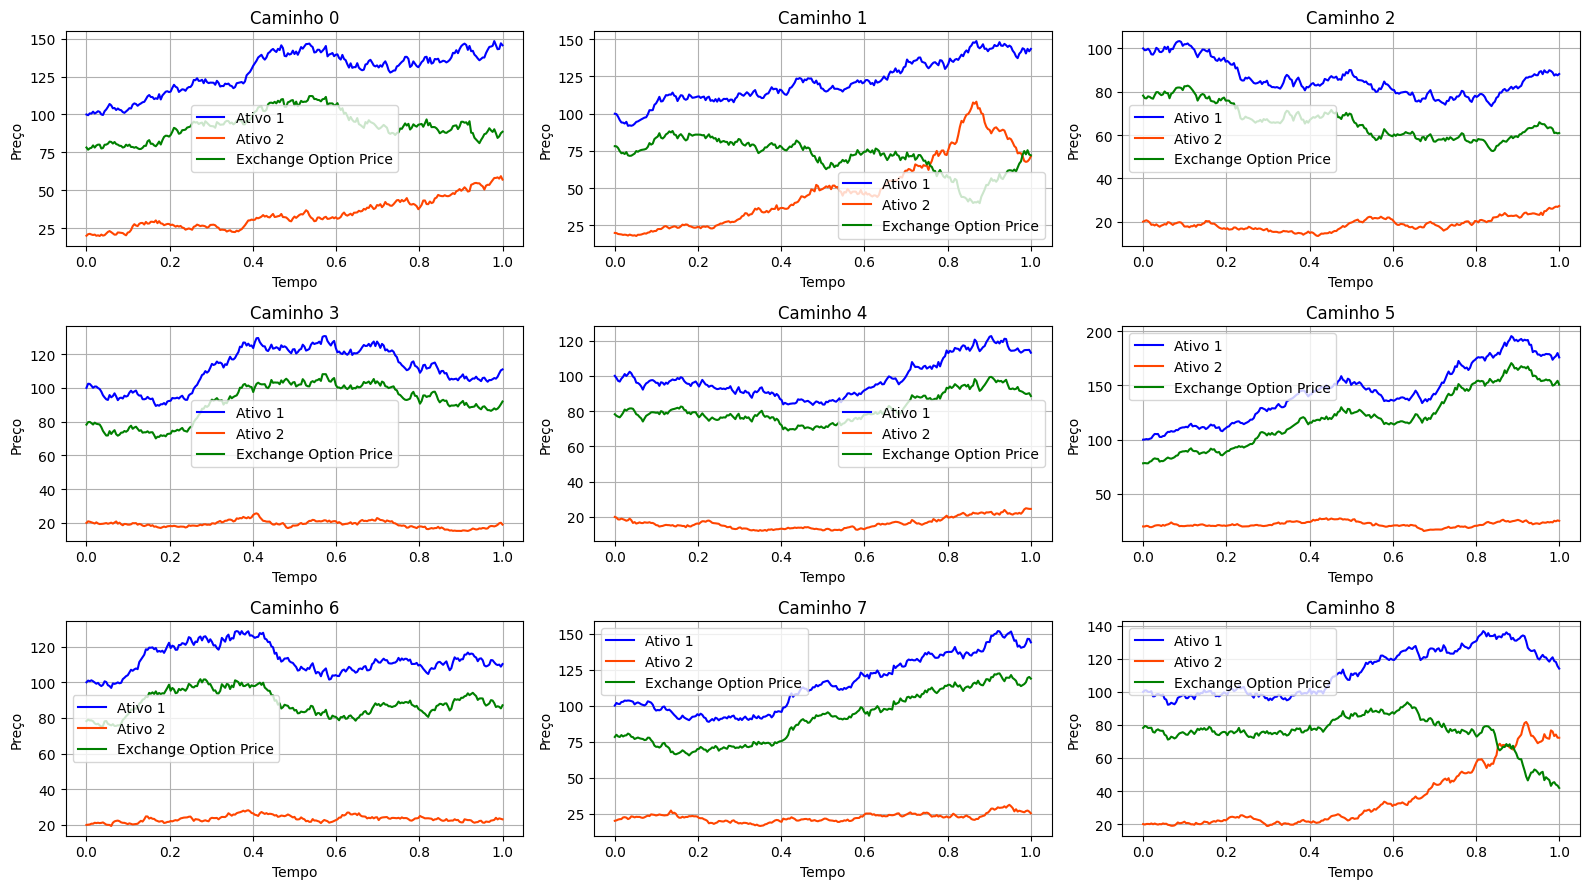

In [235]:
# Trajetórias dos ativos subjacentes
n_rows = 3
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 9))

for i in range(n_rows):
    for j in range(n_cols):
        ax = axs[i, j]

        ax.plot(S1[i*3 + j], label='Ativo 1', color='blue')
        ax.plot(S2[i*3 + j], label='Ativo 2', color='orangered')
        ax.plot(df_prices[i*3 + j], label='Exchange Option Price', color='green')
        
        ax.set_xlabel('Tempo')
        ax.set_ylabel('Preço')
        ax.set_title(f'Caminho {i*3 + j}')
        ax.grid()
        ax.legend()

plt.tight_layout()
plt.show()